**Paddy Doctor**

#Import data and libraries

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import librairies
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical

!pip install tensorflow-addons
!pip install -q -U keras-tuner
import tensorflow_addons as tfa
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##data exploration

In [ ]:
df_meta = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/paddy/train.csv")
df_meta.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/paddy/train_images"
test_path = "/content/drive/MyDrive/Colab Notebooks/paddy/test_images"

In [ ]:
disease_list = os.listdir(train_path)
n_classes = len(disease_list)
print(disease_list)
print("Total diseases number:", n_classes)

['brown_spot', 'downy_mildew', 'tungro', 'hispa', 'normal', 'bacterial_leaf_streak', 'blast', 'dead_heart', 'bacterial_panicle_blight', 'bacterial_leaf_blight']
Total diseases number: 10


In [ ]:
# Counts the number of training and testing samples in the directories
training_samples = sum([len(files) for r, d, files in os.walk(train_path)])
testing_samples = sum([len(files) for r, d, files in os.walk(test_path)])

In [ ]:
# number of pictures / class (diseases+control)

df_disease = pd.DataFrame(
    index=[disease for disease in disease_list],
    data=[len(os.listdir(train_path + "/" + name)) for name in disease_list],
    columns=["num_pictures"],
)

print("min nb of picture/disease", df_disease["num_pictures"].min())
print("max nb of picture/disease", df_disease["num_pictures"].max())
print("med nb of picture/disease", df_disease["num_pictures"].median())

min nb of picture/disease 337
max nb of picture/disease 770
med nb of picture/disease 760.0


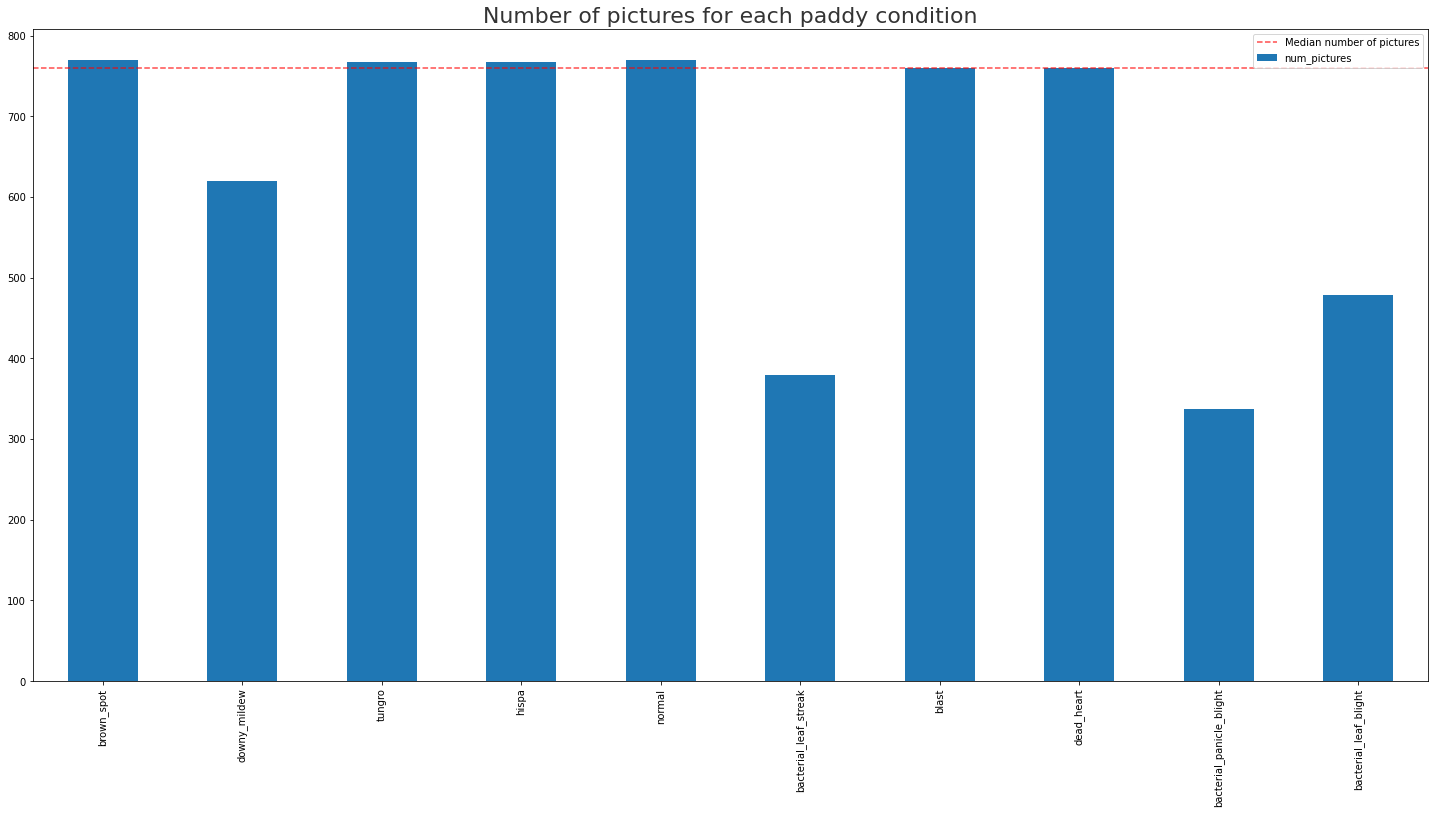

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
df_disease.plot(kind="bar", legend=True, ax=ax, label="Number of pictures")
ax.axhline(
    df_disease["num_pictures"].median(),
    color="r",
    alpha=0.7,
    linestyle="--",
    label="Median number of pictures",
)
plt.title(
    "Number of pictures for each " "paddy condition", color="#343434", fontsize=22
)
plt.legend()
plt.show()

In [ ]:
df2 = df_meta.groupby("variety")["image_id"].nunique()

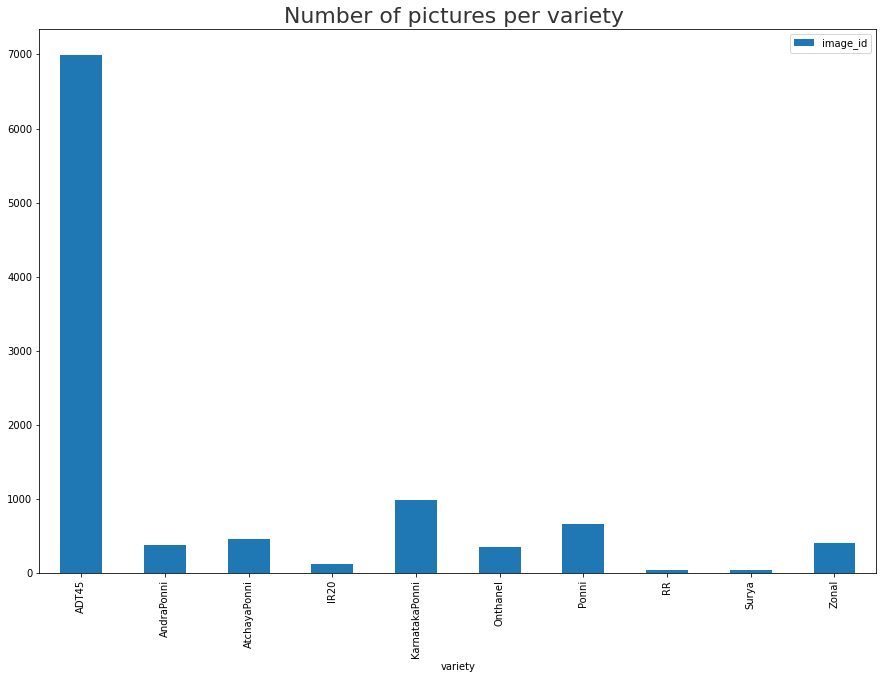

In [ ]:
# number of images / variety
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df2.plot(kind="bar", legend=True, ax=ax)

plt.title("Number of pictures per variety ", color="#343434", fontsize=22)
plt.legend()
plt.show()

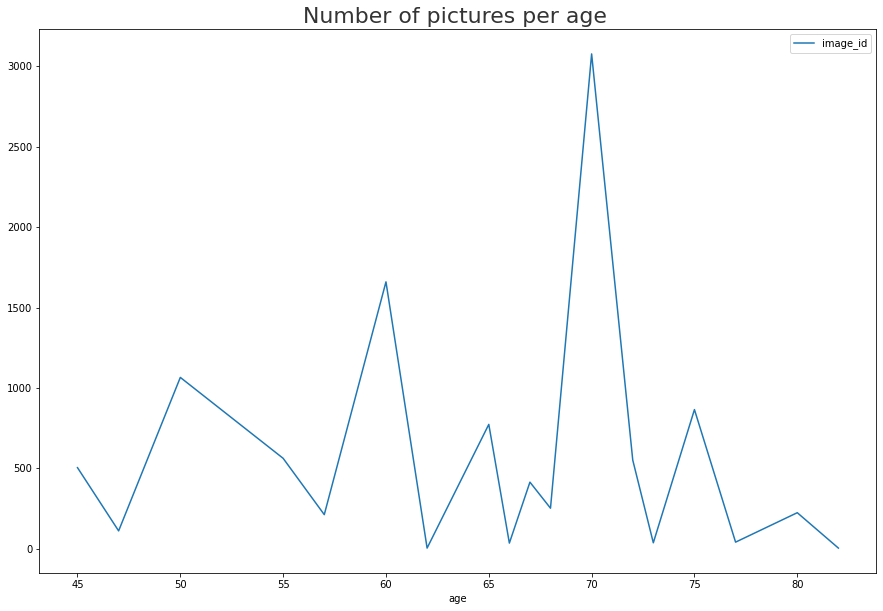

In [ ]:
df3 = df_meta.groupby("age")["image_id"].nunique()
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df3.plot(kind="line", legend=True, ax=ax)

plt.title("Number of pictures per age ", color="#343434", fontsize=22)
plt.legend()
plt.show()

In [ ]:
# visualisation of the different paddy conditions


def show_images_classes(path, classes, num_sample):

    fig = plt.figure(figsize=(20, 20))
    fig.patch.set_facecolor("#343434")
    plt.suptitle("{}".format(classes), y=0.83, color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path + "/" + classes + "/" + images[i])
        plt.subplot(num_sample // 5 + 1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()


# read images
for i in range(0, len(disease_list)):
    show_images_classes(train_dir, disease_list[i], 5)

## ResNet152v2

### preprocessing

In [ ]:
img_width = 200
img_height = 200
batch_size = 32

epochs = 100
epochs_ft = 200

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    subset="training",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

valid_generator = train_datagen.flow_from_directory(
    train_path,
    subset="validation",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 5131 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


In [ ]:
# images for prediction
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=["."],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [ ]:
# pour feature extraction
features_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
)

features_generator = features_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=None,
    class_mode="categorical",
)

Found 6411 images belonging to 10 classes.


In [ ]:
# f1_score from tensorflow_addons
f1_tfa = tfa.metrics.F1Score(num_classes=n_classes, average="macro")

In [ ]:
def plot_history(dict_history, first_score, second_score):

    """
creates two subplots for plotting 2 different metrics
called first_score and second_score against epoch number,
values obtained from the train and the validation datasets
are visualized
  """

    with plt.style.context("seaborn-whitegrid"):
        fig = plt.figure(figsize=(25, 10))

        # first suplot
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(
            dict_history.history["val_" + first_score], linestyle="--", color="orange"
        )
        plt.title(
            "Pre-trained ResNet152v2 on Paddy dataset: " + first_score, fontsize=18
        )
        plt.ylabel(first_score)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")

        # second subplot
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(
            dict_history.history["val_" + second_score], linestyle="--", color="orange"
        )
        plt.title(
            "Pre-trained ResNet152v2 on Paddy dataset: " + second_score, fontsize=18
        )
        plt.ylabel(second_score)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

##Model building

In [ ]:
# Adds new top to base model
def add_top(base):
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)

    predictions = Dense(n_classes, activation="softmax")(x)  # Output layer

    return Model(inputs=base.input, outputs=predictions)

In [ ]:
# optimizer AdaBelief
opt = tfa.optimizers.AdaBelief(
    learning_rate=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
    rectify=True,
)

In [ ]:
# Sets up model for transfer learning
def setup_model(model, base):

    for layer in base.layers:
        layer.trainable = False  # freeze base layers

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# Import the ResNet152v2 model to use as the base for our model
resnet_base = tf.keras.applications.ResNet152V2(
    input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet"
)

model = add_top(resnet_base)
setup_model(model, resnet_base)

234561536/234545216 [==============================] - 4s 0us/step


#### Train new top layers

In [ ]:
# callbacks : early stopping
early_stp = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
K.clear_session()

In [ ]:
# Train new top layers, image size = 200*200
model.fit(
    train_generator, epochs=epochs, validation_data=valid_generator, verbose=1,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
161/161 [==============================] - 98s 558ms/step - loss: 2.3944 - accuracy: 0.1495 - val_loss: 2.1151 - val_accuracy: 0.2266
Epoch 2/100
161/161 [==============================] - 85s 531ms/step - loss: 1.9701 - accuracy: 0.2982 - val_loss: 1.8068 - val_accuracy: 0.3633
Epoch 3/100
161/161 [==============================] - 86s 531ms/step - loss: 1.7330 - accuracy: 0.3970 - val_loss: 1.7270 - val_accuracy: 0.4172
Epoch 4/100
161/161 [==============================] - 86s 532ms/step - loss: 1.6219 - accuracy: 0.4407 - val_loss: 1.5964 - val_accuracy: 0.4445
Epoch 5/100
161/161 [==============================] - 85s 530ms/step - loss: 1.5698 - accuracy: 0.4537 - val_loss: 1.5500 - val_accuracy: 0.4859
Epoch 6/100
161/161 [==============================] - 85s 529ms/step - loss: 1.5192 - accuracy: 0.4769 - val_loss: 1.4875 - val_accuracy: 0.4906
Epoch 7/100
161/161 [==============================] - 85s 530ms/step - loss: 1.4398 - accuracy: 0.5020 - val_loss: 1.4251 -

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers")
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers/assets
the model is saved


In [ ]:
# load model
model = load_model(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_top_layers"
)

#### Setup model for fine tuning

In [ ]:
# Setup model for fine tuning
def setup_model(model, trainable):
    for layer in model.layers[: (len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable) :]:
        layer.trainable = True

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# Setup model to retrain our top layer plus 2 last blocks
setup_model(model, 26)

In [ ]:
# callbacks : early stopping
early_stp = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
# Fine-tune the model
history_4 = model.fit(
    train_generator,
    epochs=epochs_ft,
    validation_data=valid_generator,
    verbose=1,
    #    callbacks=early_stp
)

Epoch 1/200
161/161 [==============================] - 94s 586ms/step - loss: 0.2824 - accuracy: 0.9063 - val_loss: 0.6516 - val_accuracy: 0.8133
Epoch 2/200
161/161 [==============================] - 92s 569ms/step - loss: 0.2326 - accuracy: 0.9230 - val_loss: 0.4775 - val_accuracy: 0.8570
Epoch 3/200
161/161 [==============================] - 93s 579ms/step - loss: 0.2177 - accuracy: 0.9285 - val_loss: 0.4791 - val_accuracy: 0.8695
Epoch 4/200
161/161 [==============================] - 93s 580ms/step - loss: 0.2375 - accuracy: 0.9195 - val_loss: 0.4426 - val_accuracy: 0.8656
Epoch 5/200
161/161 [==============================] - 92s 574ms/step - loss: 0.2251 - accuracy: 0.9244 - val_loss: 0.8480 - val_accuracy: 0.7961
Epoch 6/200
161/161 [==============================] - 93s 579ms/step - loss: 0.2206 - accuracy: 0.9275 - val_loss: 0.3822 - val_accuracy: 0.8875
Epoch 7/200
161/161 [==============================] - 93s 575ms/step - loss: 0.1948 - accuracy: 0.9365 - val_loss: 0.4668 -

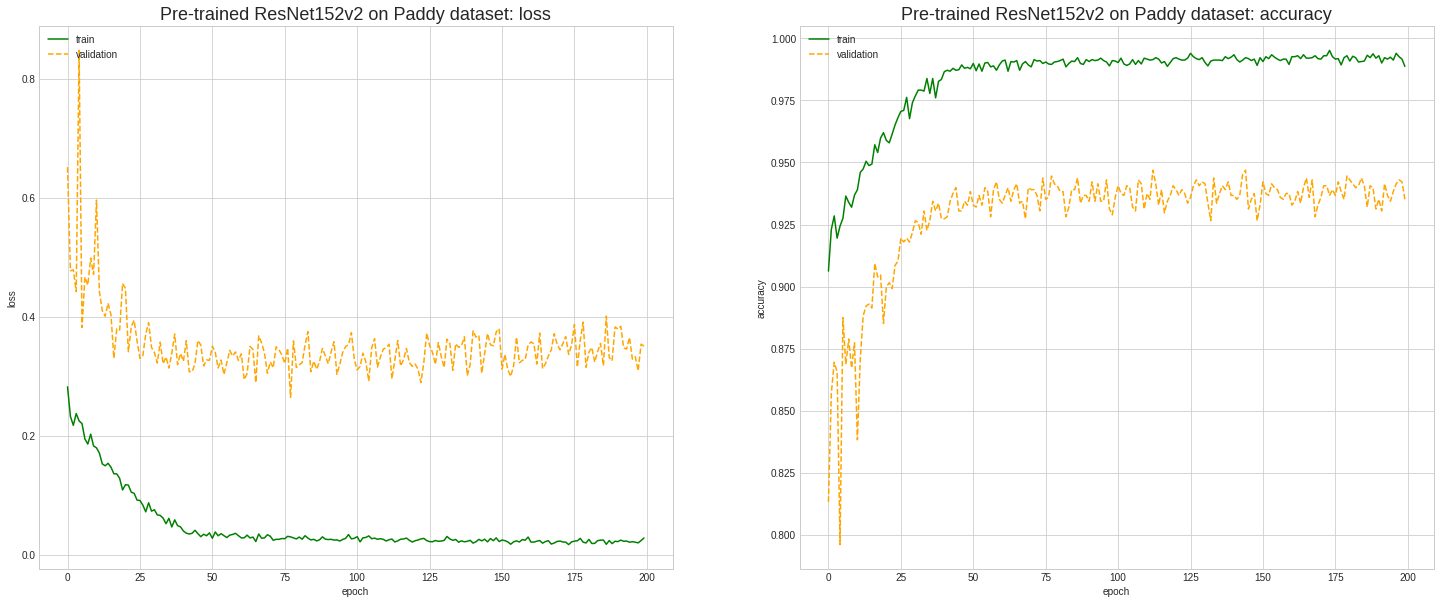

In [ ]:
plot_history(dict_history=history_4, first_score="loss", second_score="accuracy")

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_fine_tuned_26_2")
print("the model is saved")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_fine_tuned_26_2/assets
the model is saved


In [ ]:
model = load_model(
    "/content/drive/MyDrive/Colab Notebooks/paddy/paddy_resnet_fine_tuned_26_2"
)

In [ ]:
# predict sur test set avec resnet_26 layers
disease_pred = model.predict(test_generator, batch_size=32,)

In [ ]:
# formatting Kaggle submission
predicted_class_indices = np.argmax(disease_pred, axis=1)
print(set(predicted_class_indices))

inv_map = {v: k for k, v in train_generator.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({"image_id": filenames, "label": predictions})
results.image_id = results.image_id.str.replace("./", "")
results.to_csv("submission7.csv", index=False)
results.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
